In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from imblearn.metrics import classification_report_imbalanced
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import imblearn
import warnings

warnings.filterwarnings('ignore')

In [2]:
#df = pd.read_csv('/kaggle/input/diabetic-patients-readmission-prediction/diabetic_data.csv')
df = pd.read_csv('diabetic_data.csv')
print(df.shape)
df.head()

(101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
len(set(df.patient_nbr))

71518

# Initial depuration and label encoding

In [4]:
def remove_outliers(df, out_cols, T=1.5, verbose=True):
    # Copy of df
    new_df = df.copy()
    init_shape = new_df.shape
    # For each column
    for c in out_cols:
        q1 = new_df[c].quantile(.25)
        q3 = new_df[c].quantile(.75)
        col_iqr = q3 - q1
        col_max = q3 + T * col_iqr
        col_min = q1 - T * col_iqr
        # Filter data without outliers and ignoring nan
        filtered_df = new_df[(new_df[c] <= col_max) & (new_df[c] >= col_min)]
        if verbose:
            n_out = new_df.shape[0] - filtered_df.shape[0] 
            print(f" Columns {c} had {n_out} outliers removed")
        new_df = filtered_df
            
    if verbose:
        # Print shrink percentage
        lines_red = df.shape[0] - new_df.shape[0]
        print(f"Data reduced by {lines_red} lines, or {lines_red/df.shape[0]*100:.2f} %")
    return new_df

In [5]:
#Data Cleaning
df = df.drop(columns=['weight', 'payer_code', 'medical_specialty','admission_type_id','discharge_disposition_id','admission_source_id'])
df = df.dropna()
df = df[df.race != '?']
df = df[df.diag_1 != '?']
df = df[df.diag_2 != '?']
df = df[df.diag_3 != '?']
df = df[df.gender != 'Unknown/Invalid']
df = df[df.number_outpatient < 17]
df = df[df.number_emergency < 14]
df = df[df.number_inpatient < 14]
df = df[df.number_diagnoses < 10]
df = df[df.number_diagnoses < 10]
df.number_outpatient = df.number_outpatient.mask(df.number_outpatient > 7, 8)
df.number_emergency = df.number_emergency.mask(df.number_emergency > 5, 6)
df.number_inpatient = df.number_inpatient.mask(df.number_inpatient > 9, 10)
df = remove_outliers(df, ['num_lab_procedures','num_medications'])

 Columns num_lab_procedures had 141 outliers removed
 Columns num_medications had 3264 outliers removed
Data reduced by 3405 lines, or 3.48 %


In [6]:
#Labeling
diseases = ['metformin', 'repaglinide', 'nateglinide',
'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
'insulin', 'glyburide-metformin', 'glipizide-metformin',
'glimepiride-pioglitazone', 'metformin-rosiglitazone',
'metformin-pioglitazone', 'change']

df = df.replace({'readmitted' : { 'NO' : 0, '<30' : 2, '>30' : 1}}) #output feacture
df = df.replace({'diabetesMed' : { 'No' : 0, 'Yes' : 1}})
df = df.replace({'max_glu_serum' : { 'None' : 0, 'Norm' : 1, '>200' : 2, '>300' : 3}})
df = df.replace({'A1Cresult' : { 'None' : 0, 'Norm' : 1, '>7' : 2, '>8' : 3}})
df = df.replace({'gender' : { 'Female' : 0, 'Male' : 1}})
df = df.replace({'race' : { 'AfricanAmerican' : 0, 'Asian' : 1, 'Caucasian' : 2, 'Hispanic' : 3, 'Other' : 4}})
df = df.replace({'age' : { 'Female' : 0, 'Male' : 1}})
df = df.replace({'age' : { '[0-10)' : 0, '[10-20)' : 1, '[20-30)' : 2, '[30-40)' : 3, '[40-50)' : 4,
                           '[50-60)' : 5, '[60-70)' : 6, '[70-80)' : 7, '[80-90)' : 8, '[90-100)' : 9}})

opts = {'No': 0, 'Down': 1, 'Steady': 1, 'Up': 1}
opts1 = {'No': 0, 'Steady': 1}
opts2 = {'No': 0}
opts3 = {'No': 0, 'Steady': 1, 'Up': 1}
opts4 = {'No': 0, 'Ch' : 1}

encoding = []

for i in diseases:
    if set(df[i]) == opts.keys(): labeling = {i : opts} 
    elif set(df[i]) == opts1.keys(): labeling = {i : opts1} 
    elif set(df[i]) == opts2.keys(): labeling = {i : opts2}
    elif set(df[i]) == opts3.keys(): labeling = {i : opts3} 
    elif set(df[i]) == opts4.keys(): labeling = {i : opts4} 
    df = df.replace(labeling)
    encoding.append([labeling])
    
df['minor_diabetes_med'] = df.chlorpropamide + df.tolbutamide + df.miglitol+ df.troglitazone+ df.tolazamide+ df['glipizide-metformin']+ df['glimepiride-pioglitazone']+ df['metformin-rosiglitazone']

In [7]:
def diagTreatmeant(dataframe):
    exclude = {'428':19 ,'414':20 ,'786':21 ,'486':22 ,'410':23 ,'427':24 ,'491':25, '715':26 ,'434':26 ,'780':27 ,'682':28 ,'996':28 ,'276':29 ,'250.8':30}
    newData = []
    for i in dataframe:
        if i.find('V') == -1 and i.find('E') == -1:
            tmp = float(i)
            if not i in exclude.keys():
                if tmp >= 1 and tmp <= 139:
                    newData.append(1)
                elif tmp >= 140 and tmp <= 239:
                    newData.append(2)
                elif tmp >= 240 and tmp <= 279:
                    newData.append(3)
                elif tmp >= 280 and tmp <= 289:
                    newData.append(4)
                elif tmp >= 290 and tmp <= 319:
                    newData.append(5)
                elif tmp >= 320 and tmp <= 389:
                    newData.append(6)
                elif tmp >= 390 and tmp <= 459:
                    newData.append(7)
                elif tmp >= 460 and tmp <= 519:
                    newData.append(8)
                elif tmp >= 520 and tmp <= 579:
                    newData.append(9)
                elif tmp >= 580 and tmp <= 629:
                    newData.append(10)
                elif tmp >= 630 and tmp <= 679:
                    newData.append(11)
                elif tmp >= 680 and tmp <= 709:
                    newData.append(12)
                elif tmp >= 710 and tmp <= 739:
                    newData.append(13)
                elif tmp >= 740 and tmp <= 759:
                    newData.append(14)
                elif tmp >= 760 and tmp <= 779:
                    newData.append(15)
                elif tmp >= 780 and tmp <= 799:
                    newData.append(16)
                else:
                    newData.append(17)
            else:
                newData.append(exclude[i])
        else:
            if i.find('V') != -1:
                newData.append(18)
            else:
                newData.append(31)
    return newData

# Data processing

In [8]:
#Split output feacture
data = df.copy()
data = data.drop_duplicates(subset=['patient_nbr'])
data = data.drop(columns=['encounter_id', 'patient_nbr'])
y = pd.DataFrame(data.readmitted.copy())
data = data.drop(columns=['readmitted'])
data.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
       'minor_diabetes_med'],
      dtype='object')

In [9]:
#Diagnostic gouping accord to ICD9
data.diag_1 = diagTreatmeant(data.diag_1)
data.diag_2 = diagTreatmeant(data.diag_2)
data.diag_3 = diagTreatmeant(data.diag_3)
data = data.drop(columns=['acetohexamide', 'examide', 'citoglipton', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'chlorpropamide','tolbutamide','miglitol','troglitazone','tolazamide','glipizide-metformin','glimepiride-pioglitazone'])
ordinal_features = ['diag_1','diag_2', 'diag_3', 'race', 'age']
ce_ord = ce.TargetEncoder(cols = ordinal_features)
data = ce_ord.fit_transform(data, y)
ce_by = ce.BinaryEncoder(cols = diseases)
data = ce_ord.fit_transform(data, y)

In [10]:
#Numeric data scale
numeric_feactures = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
scaler = MinMaxScaler()
data[numeric_feactures] = scaler.fit_transform(data[numeric_feactures])

<AxesSubplot:>

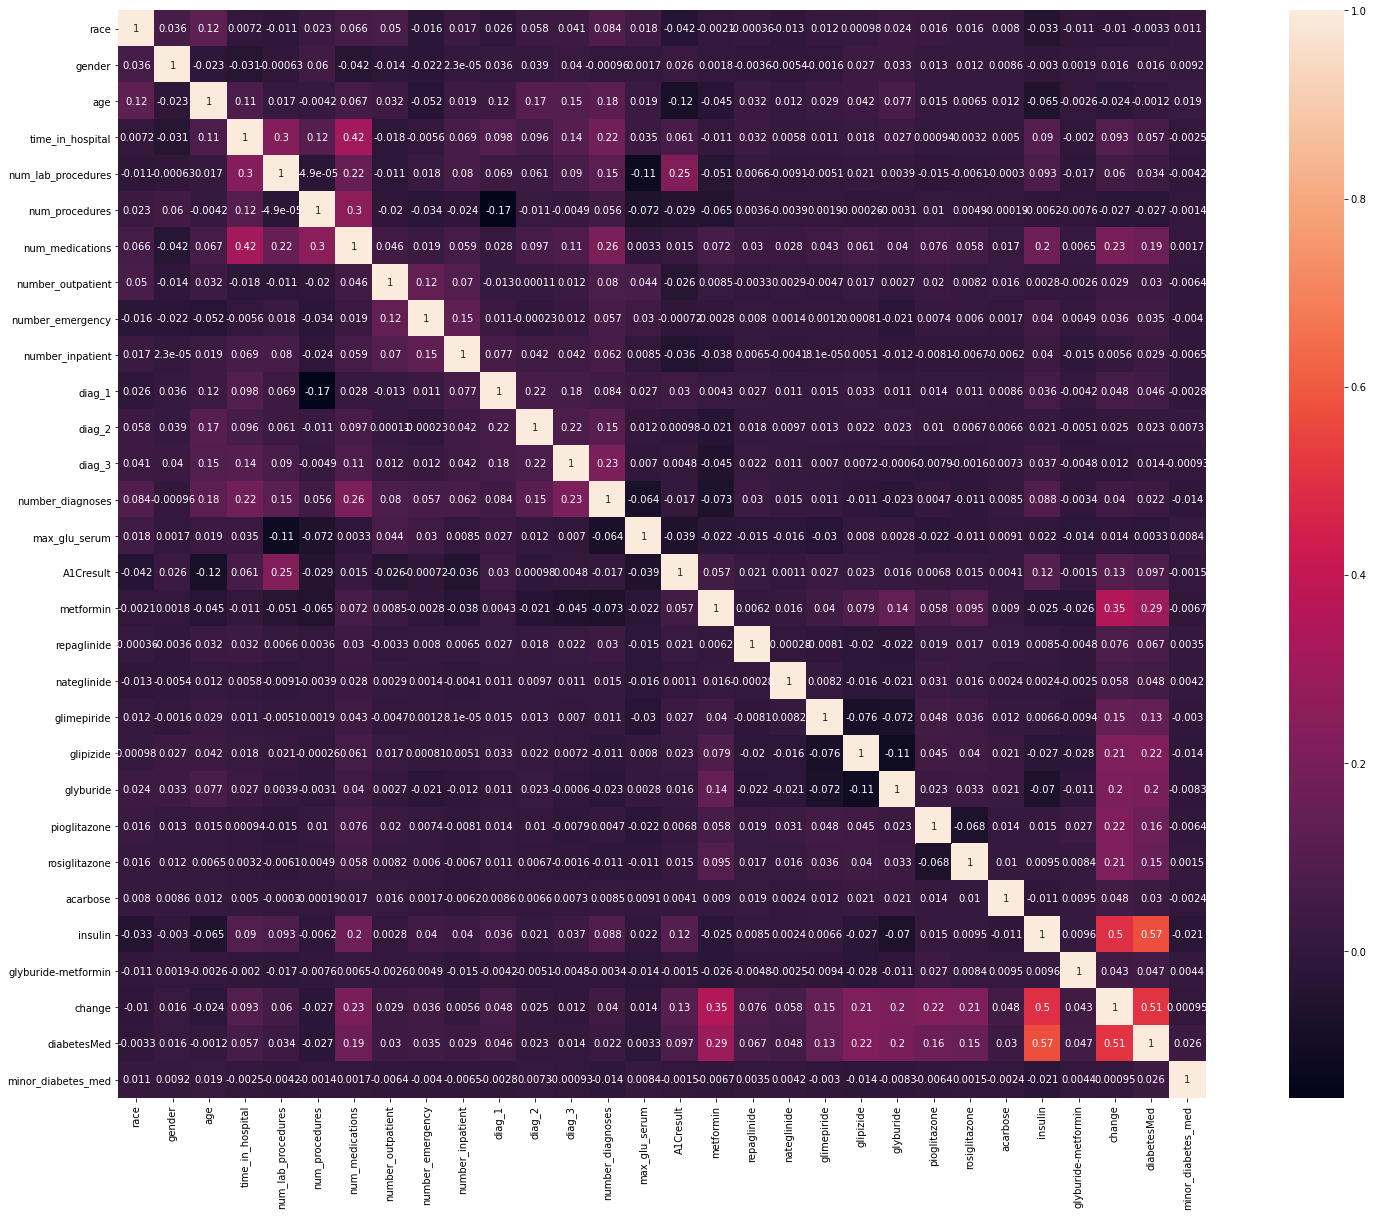

In [22]:
#Feacture correlation
plt.figure(figsize=(30, 20))
sns.heatmap(data.corr(method = 'kendall'), annot = data.corr(), square = True)

In [11]:
data['readmitted'] = y 

### No readmitted, 30< readmitted model 

<AxesSubplot:xlabel='[No readmitted, 30< readmitted]'>

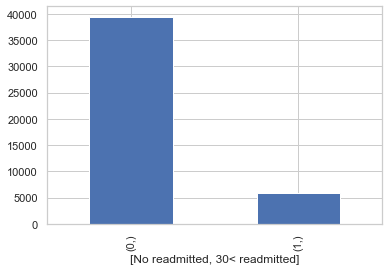

In [63]:
process_data = data.copy()
process_data = process_data[process_data.readmitted != 1]
process_data = process_data.replace({'readmitted' : { 2 : 1}}) #output feacture
y = pd.DataFrame(process_data.readmitted.copy())
process_data = process_data.drop(columns=['readmitted'])
#Label 0: No readmitted
#Label 1: 30< readmitted
y.value_counts().plot.bar(xlabel=['No readmitted','30< readmitted'])

In [64]:
#Train test scolumnst
def train_test_split_generator(data, y, smote):   
    x_train, x_test, y_train, y_test = train_test_split(data, y ,test_size = 0.2, random_state=42, stratify = y)
    
    if (smote):
        sm = BorderlineSMOTE(random_state=42,k_neighbors=3)
        x_train, y_train = sm.fit_resample(x_train, y_train)
    
    print(y_train.value_counts().sort_index())
    print(y_test.value_counts().sort_index())
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('int')

    x_train=x_train.values
    y_train=y_train.values.reshape((-1))


    x_test = x_test.astype('float64')
    y_test = y_test.astype('int')

    x_test=x_test.values
    y_test=y_test.values.reshape((-1))
    
    return x_train, x_test, y_train, y_test
    
x_train, x_test, y_train, y_test = train_test_split_generator(process_data, y, False)

readmitted
0             31561
1              4745
dtype: int64
readmitted
0             7891
1             1186
dtype: int64


In [65]:
#Class weight calculation
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))) 
sample_weights = [class_weights[y] for y in y_train]
train_sample_weight = sample_weights
print(class_weights)

{0: 0.5751718893571179, 1: 3.8257112750263436}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

#RandomForestClassifier
param_grid = {
    'max_depth': [6, 10, 17, 40],
    'n_estimators': [50, 100, 200, 300, 1000]
}
clf = RandomForestClassifier(class_weight=class_weights)
param_grid = GridSearchCV(estimator = clf, scoring = 'roc_auc_ovr', param_grid = param_grid, cv = StratifiedKFold(n_splits=5), verbose=4, n_jobs = -1)
param_grid.fit(x_train, y_train)
param_grid.best_params_
#6-300

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

# GradientBoostingClassifier
param_grid = {
    'n_estimators': [100, 300, 1000],
    'learning_rate' : [0.01, 0.1, 0.001]
}

clf = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = clf, scoring = 'roc_auc_ovo', param_grid = param_grid, cv = StratifiedKFold(n_splits=5), verbose=10, n_jobs = -1)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'learning_rate': 0.01, 'n_estimators': 1000}

In [29]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# GradientBoostingClassifier
param_grid = {
    'reg_param': [0.0001, 0.001,0.01, 0.1], 
    'store_covariance': [True, False],
    'tol': [0.0001, 0.001,0.01, 0.1], 
}

clf = QuadraticDiscriminantAnalysis()
grid_search = GridSearchCV(estimator = clf, scoring = 'roc_auc_ovo', param_grid = param_grid, cv = StratifiedKFold(n_splits=5), verbose=10, n_jobs = -1)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


{'reg_param': 0.0001, 'store_covariance': True, 'tol': 0.0001}

In [32]:
from sklearn.svm import SVC

# GradientBoostingClassifier
param_grid = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf']
}

clf = SVC()
grid_search = GridSearchCV(estimator = clf, scoring = 'roc_auc_ovo', param_grid = param_grid, cv = StratifiedKFold(n_splits=5), verbose=10, n_jobs = -1)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [66]:
import keras
from keras.optimizers import adam_v2
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=8, min_lr=1e-6,verbose = 1)
custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=20
)

METRICS = [ 
      keras.metrics.AUC(name='auc'),
]

d1 = 0.15


#model definition
def create_model(learn_rate):
    model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.selu, kernel_initializer = initializers.he_normal,bias_initializer=initializers.he_normal, input_shape=(x_train.shape[1],)),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
    
    keras.layers.Dense(90, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(80, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(70, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(60, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(50, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(40, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(30, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(20, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(10, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
 keras.layers.Dense(1, activation=  'sigmoid')
 ])
    optimizer = adam_v2.Adam(lr=learn_rate)
    model.compile(loss='binary_crossentropy', metrics=[METRICS], optimizer=optimizer)
    return model


# Merge inputs and targets
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

max_n = 4.
num_folds = 5

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
confusions_matrix = []
for train, test in kfold.split(inputs, targets):
      # Compile the model
    model = create_model(0.1)
    
    X_train_res, y_train_res = inputs[train], targets[train]
    X_test_res, y_test_res = inputs[test], targets[test]
        
      # Generate a print
    print('-----------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model , class_weight=class_weight
    history = model.fit(X_train_res, y_train_res, class_weight=class_weights, validation_data=(X_test_res, y_test_res),batch_size=256, epochs=100,callbacks=[custom_early_stopping, reduce_lr])

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fig, axs = plt.subplots(2)
    fig.suptitle('model loss')
    fig.legend(['train', 'val'], loc='upper left')

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[1].plot(history.history['auc'])
    axs[1].plot(history.history['val_auc'])

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

      # Increase fold number
    fold_no = fold_no + 1

-----------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
142/142 [==============================] - 35s 109ms/step - loss: 0.7006 - auc: 0.5313 - val_loss: 1.7420 - val_auc: 0.6018
Epoch 2/100
142/142 [==============================] - 15s 104ms/step - loss: 0.6854 - auc: 0.5753 - val_loss: 0.8463 - val_auc: 0.6019
Epoch 3/100
142/142 [==============================] - 16s 109ms/step - loss: 0.6713 - auc: 0.6023 - val_loss: 2.3074 - val_auc: 0.6310
Epoch 4/100
142/142 [==============================] - 13s 92ms/step - loss: 0.6745 - auc: 0.6115 - val_loss: 0.5734 - val_auc: 0.6266
Epoch 5/100
 19/142 [===>..........................] - ETA: 10s - loss: 0.6700 - auc: 0.6394

KeyboardInterrupt: 

## Predict

In [43]:
clf_Q1 = QuadraticDiscriminantAnalysis(reg_param=0.0001, store_covariance=True, tol=0.0001).fit(x_train, y_train)
clf_S1 = SVC(C=0.1, gamma=1, kernel='rbf').fit(x_train, y_train, sample_weight=train_sample_weight)
clf_G1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000).fit(x_train, y_train)
clf_R1 = RandomForestClassifier(max_depth=6, n_estimators=300,class_weight=class_weights).fit(x_train, y_train)

ROC AUC: 0.558
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.89      0.23      0.89      0.45      0.22      7891
          1       0.23      0.23      0.89      0.23      0.45      0.19      1186

avg / total       0.80      0.80      0.31      0.80      0.45      0.21      9077



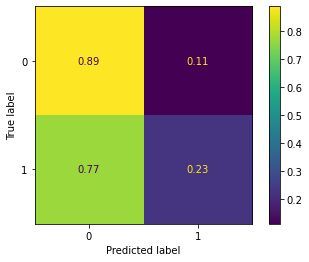

In [90]:
# Predict QuadraticDiscriminantAnalysis
y_1 = clf_Q1.predict(x_test)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

ROC AUC: 0.563
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.64      0.49      0.74      0.56      0.32      7891
          1       0.17      0.49      0.64      0.25      0.56      0.31      1186

avg / total       0.80      0.62      0.51      0.68      0.56      0.31      9077



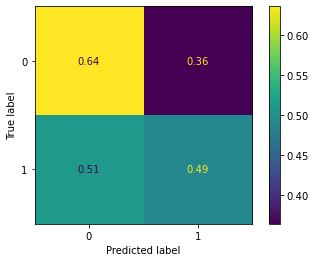

In [91]:
# Predict SVC
y_1 = clf_S1.predict(x_test)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

ROC AUC: 0.563
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.64      0.49      0.74      0.56      0.32      7891
          1       0.17      0.49      0.64      0.25      0.56      0.31      1186

avg / total       0.80      0.62      0.51      0.68      0.56      0.31      9077



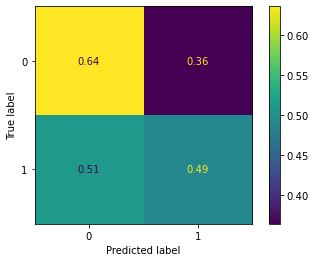

In [92]:
# Predict GradientBoostingClassifier
y_1 = clf_G1.predict(x_test)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

ROC AUC: 0.601
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.69      0.51      0.78      0.59      0.36      7891
          1       0.20      0.51      0.69      0.29      0.59      0.35      1186

avg / total       0.81      0.67      0.53      0.72      0.59      0.36      9077



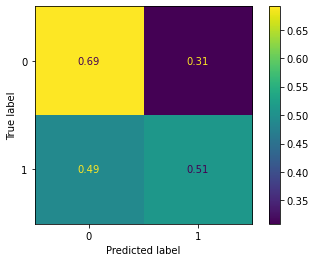

In [93]:
# Predict RandomForestClassifier
y_1 = clf_R1.predict(x_test)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

ROC AUC: 0.607
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.55      0.66      0.69      0.60      0.36      7891
          1       0.18      0.66      0.55      0.28      0.60      0.37      1186

avg / total       0.82      0.57      0.65      0.64      0.60      0.36      9077



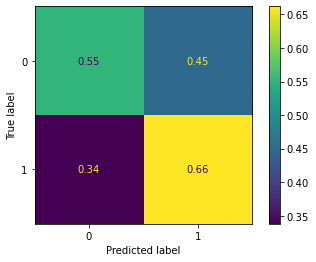

In [96]:
# Predict
y_pred = model.predict(x_test)
y_1 = np.round(y_pred)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

## Predict with SMOTE

In [36]:
x_train, x_test, y_train, y_test = train_test_split_generator(process_data, y, True)

readmitted
0             31561
1             31561
dtype: int64
readmitted
0             7891
1             1186
dtype: int64


ROC AUC: 0.551
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.25      0.85      0.40      0.46      0.20      7891
          1       0.15      0.85      0.25      0.25      0.46      0.23      1186

avg / total       0.82      0.33      0.77      0.38      0.46      0.21      9077



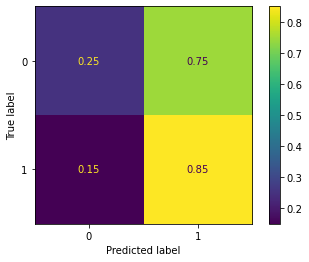

In [37]:
# Predict QuadraticDiscriminantAnalysis
clf_Q1 = QuadraticDiscriminantAnalysis(reg_param=0.0001, store_covariance=True, tol=0.0001).fit(x_train, y_train)

y_1 = clf_Q1.predict(x_test)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

ROC AUC: 0.574
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.63      0.51      0.74      0.57      0.33      7891
          1       0.17      0.51      0.63      0.26      0.57      0.32      1186

avg / total       0.80      0.62      0.53      0.68      0.57      0.33      9077



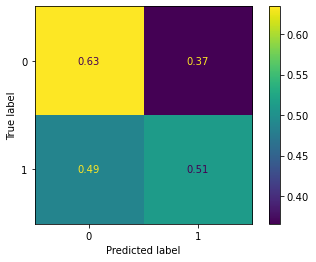

In [40]:
# Predict SVC
clf_S1 = SVC(C=0.1, gamma=1, kernel='rbf').fit(x_train, y_train)

y_1 = clf_S1.predict(x_test)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

ROC AUC: 0.520
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.99      0.05      0.93      0.22      0.05      7891
          1       0.43      0.05      0.99      0.09      0.22      0.04      1186

avg / total       0.82      0.87      0.17      0.82      0.22      0.05      9077



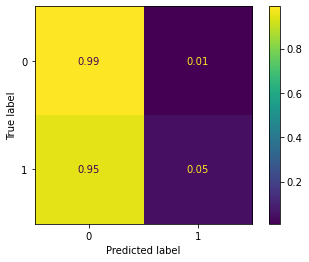

In [39]:
# Predict GradientBoostingClassifier
clf_G1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000).fit(x_train, y_train)

y_1 = clf_G1.predict(x_test)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

ROC AUC: 0.565
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.80      0.33      0.84      0.52      0.28      7891
          1       0.20      0.33      0.80      0.25      0.52      0.25      1186

avg / total       0.80      0.74      0.40      0.76      0.52      0.28      9077



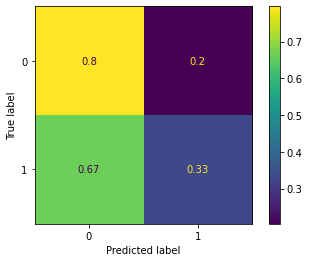

In [38]:
# Predict RandomForestClassifier
clf_R1 = RandomForestClassifier(max_depth=6, n_estimators=300).fit(x_train, y_train)
y_1 = clf_R1.predict(x_test)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

-----------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
226/226 [==============================] - 33s 27ms/step - loss: 0.6825 - auc: 0.5930 - val_loss: 0.8204 - val_auc: 0.6706
Epoch 2/100
226/226 [==============================] - 5s 23ms/step - loss: 0.6470 - auc: 0.6621 - val_loss: 0.7279 - val_auc: 0.6826
Epoch 3/100
226/226 [==============================] - 5s 23ms/step - loss: 0.6386 - auc: 0.6774 - val_loss: 0.6924 - val_auc: 0.6828
Epoch 4/100
226/226 [==============================] - 5s 23ms/step - loss: 0.6341 - auc: 0.6838 - val_loss: 0.6298 - val_auc: 0.6936
Epoch 5/100
226/226 [==============================] - 5s 23ms/step - loss: 0.6323 - auc: 0.6880 - val_loss: 0.7336 - val_auc: 0.6947
Epoch 6/100
226/226 [==============================] - 6s 24ms/step - loss: 0.6281 - auc: 0.6958 - val_loss: 0.6895 - val_auc: 0.7013
Epoch 7/100
226/226 [==============================] - 6s 24ms/step - loss: 0.6256 - auc: 0.6984 - 

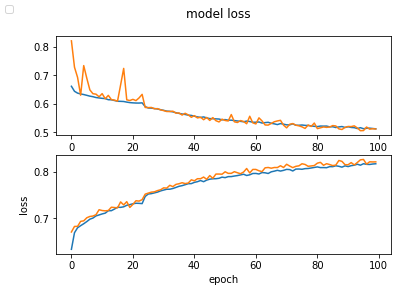

-----------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
226/226 [==============================] - 16s 41ms/step - loss: 0.6774 - auc: 0.7105 - val_loss: 0.7957 - val_auc: 0.6613
Epoch 2/100
226/226 [==============================] - 9s 39ms/step - loss: 0.6497 - auc: 0.6592 - val_loss: 0.6534 - val_auc: 0.6843
Epoch 3/100
226/226 [==============================] - 8s 37ms/step - loss: 0.6403 - auc: 0.6733 - val_loss: 0.6351 - val_auc: 0.6935
Epoch 4/100
226/226 [==============================] - 19s 84ms/step - loss: 0.6407 - auc: 0.6747 - val_loss: 0.6799 - val_auc: 0.6967
Epoch 5/100
226/226 [==============================] - 21s 95ms/step - loss: 0.6354 - auc: 0.6830 - val_loss: 0.6696 - val_auc: 0.6837
Epoch 6/100
226/226 [==============================] - 17s 75ms/step - loss: 0.6346 - auc: 0.6841 - val_loss: 0.6572 - val_auc: 0.6966
Epoch 7/100
226/226 [==============================] - 16s 70ms/step - loss: 0.6257 - auc: 0.697

KeyboardInterrupt: 

In [42]:
import keras
from keras.optimizers import adam_v2
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=8, min_lr=1e-6,verbose = 1)
custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=20
)

METRICS = [ 
      keras.metrics.AUC(name='auc'),
]

d1 = 0.15


#model definition
def create_model(learn_rate):
    model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.selu, kernel_initializer = initializers.he_normal,bias_initializer=initializers.he_normal, input_shape=(x_train.shape[1],)),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(80, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(70, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(50, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(30, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(10, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
 keras.layers.Dense(1, activation=  'sigmoid')
 ])
    optimizer = adam_v2.Adam(lr=learn_rate)
    model.compile(loss='binary_crossentropy', metrics=[METRICS], optimizer=optimizer)
    return model


# Merge inputs and targets
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

max_n = 4.
num_folds = 5

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
confusions_matrix = []
for train, test in kfold.split(inputs, targets):
      # Compile the model
    model = create_model(0.1)
    
    X_train_res, y_train_res = inputs[train], targets[train]
    X_test_res, y_test_res = inputs[test], targets[test]
        
      # Generate a print
    print('-----------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model , class_weight=class_weight
    history = model.fit(X_train_res, y_train_res, validation_data=(X_test_res, y_test_res),batch_size=256, epochs=100,callbacks=[custom_early_stopping, reduce_lr])

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fig, axs = plt.subplots(2)
    fig.suptitle('model loss')
    fig.legend(['train', 'val'], loc='upper left')

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[1].plot(history.history['auc'])
    axs[1].plot(history.history['val_auc'])

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

      # Increase fold number
    fold_no = fold_no + 1

ROC AUC: 0.596
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.82      0.37      0.86      0.55      0.32      7891
          1       0.24      0.37      0.82      0.29      0.55      0.29      1186

avg / total       0.81      0.76      0.43      0.78      0.55      0.32      9077



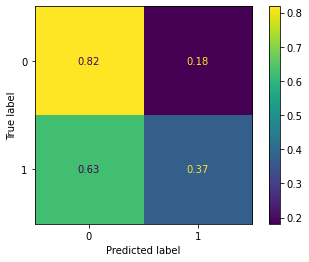

In [43]:
# Predict Neural network
y_pred = model.predict(x_test)
y_1 = np.round(y_pred)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

## Feacture selection

In [67]:
process_data = data.copy()
process_data = process_data[process_data.readmitted != 1]
process_data = process_data.replace({'readmitted' : { 2 : 1}}) #output feacture
y = pd.DataFrame(process_data.readmitted.copy())
process_data = process_data.drop(columns=['readmitted'])
x_train, x_test, y_train, y_test = train_test_split_generator(process_data, y, False)

readmitted
0             31561
1              4745
dtype: int64
readmitted
0             7891
1             1186
dtype: int64


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
clf_R1 = RandomForestClassifier(max_depth=6, n_estimators=300,class_weight=class_weights)
sfs = SequentialFeatureSelector(clf_R1, direction='backward', scoring='roc_auc_ovo')
sfs.fit(x_train, y_train)

In [ ]:
sfs.get_support()

In [ ]:
x_train_red = sfs.fit_transform(x_train)
x_test_red = sfs.fit_transform(x_test)

In [56]:
clf_S1 = SVC(C=0.1, gamma=1, kernel='rbf').fit(x_train_red, y_train, sample_weight=train_sample_weight)
clf_R1 = RandomForestClassifier(max_depth=6, n_estimators=300,class_weight=class_weights).fit(x_train_red, y_train)

ROC AUC: 0.561
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.54      0.58      0.67      0.56      0.31      7891
          1       0.16      0.58      0.54      0.25      0.56      0.32      1186

avg / total       0.80      0.54      0.58      0.62      0.56      0.31      9077



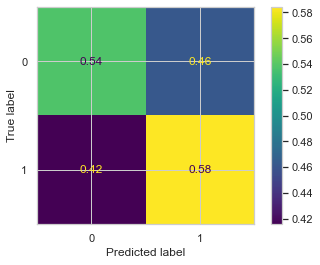

In [54]:
# Predict SVC
y_1 = clf_S1.predict(x_test_red)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

ROC AUC: 0.580
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.62      0.54      0.73      0.58      0.34      7891
          1       0.18      0.54      0.62      0.27      0.58      0.33      1186

avg / total       0.81      0.61      0.55      0.67      0.58      0.34      9077



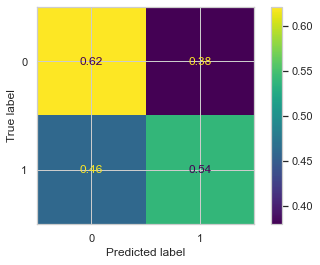

In [58]:
# Predict RandomForestClassifier
y_1 = clf_R1.predict(x_test_red)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

-----------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
142/142 [==============================] - 13s 40ms/step - loss: 0.7064 - auc: 0.5359 - val_loss: 0.8603 - val_auc: 0.5869
Epoch 2/100
142/142 [==============================] - 5s 32ms/step - loss: 0.6875 - auc: 0.5601 - val_loss: 1.1656 - val_auc: 0.6070
Epoch 3/100
142/142 [==============================] - 5s 32ms/step - loss: 0.6874 - auc: 0.5754 - val_loss: 0.6233 - val_auc: 0.6051
Epoch 4/100
142/142 [==============================] - 4s 32ms/step - loss: 0.6827 - auc: 0.5811 - val_loss: 0.7500 - val_auc: 0.6041
Epoch 5/100
142/142 [==============================] - 5s 33ms/step - loss: 0.6848 - auc: 0.5648 - val_loss: 0.9807 - val_auc: 0.6046
Epoch 6/100
142/142 [==============================] - 5s 33ms/step - loss: 0.6847 - auc: 0.5866 - val_loss: 0.6943 - val_auc: 0.6067
Epoch 7/100
142/142 [==============================] - 4s 31ms/step - loss: 0.6976 - auc: 0.5785 - 

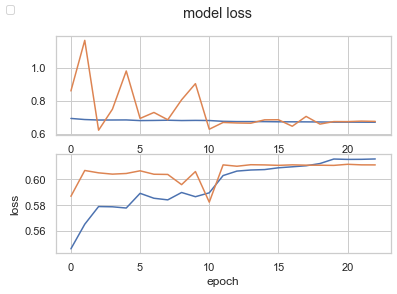

-----------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
142/142 [==============================] - 22s 92ms/step - loss: 0.7127 - auc: 0.5705 - val_loss: 1.1671 - val_auc: 0.5741
Epoch 2/100
142/142 [==============================] - 11s 78ms/step - loss: 0.6907 - auc: 0.5740 - val_loss: 1.1153 - val_auc: 0.5785
Epoch 3/100
142/142 [==============================] - 11s 79ms/step - loss: 0.6810 - auc: 0.5821 - val_loss: 0.7357 - val_auc: 0.5825
Epoch 4/100
142/142 [==============================] - 9s 62ms/step - loss: 0.6800 - auc: 0.5852 - val_loss: 0.9090 - val_auc: 0.5781
Epoch 5/100
142/142 [==============================] - 9s 63ms/step - loss: 0.6932 - auc: 0.5777 - val_loss: 0.9917 - val_auc: 0.5839
Epoch 6/100
142/142 [==============================] - 8s 58ms/step - loss: 0.6816 - auc: 0.5973 - val_loss: 0.9624 - val_auc: 0.5878
Epoch 7/100
142/142 [==============================] - 8s 59ms/step - loss: 0.6850 - auc: 0.5951 

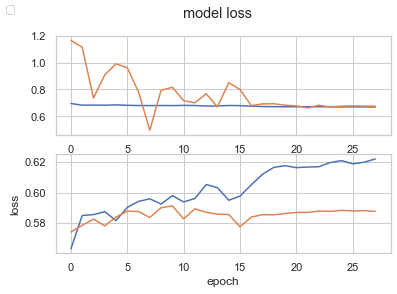

-----------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
142/142 [==============================] - 26s 75ms/step - loss: 0.7028 - auc: 0.5568 - val_loss: 0.7979 - val_auc: 0.5929
Epoch 2/100
142/142 [==============================] - 8s 57ms/step - loss: 0.6918 - auc: 0.5604 - val_loss: 0.5214 - val_auc: 0.5906
Epoch 3/100
142/142 [==============================] - 9s 61ms/step - loss: 0.6770 - auc: 0.5835 - val_loss: 0.5723 - val_auc: 0.5950
Epoch 4/100
142/142 [==============================] - 8s 59ms/step - loss: 0.6868 - auc: 0.5797 - val_loss: 0.7189 - val_auc: 0.5909
Epoch 5/100
142/142 [==============================] - 9s 64ms/step - loss: 0.6863 - auc: 0.5801 - val_loss: 0.5581 - val_auc: 0.5851
Epoch 6/100
142/142 [==============================] - 13s 89ms/step - loss: 0.6896 - auc: 0.5743 - val_loss: 0.6235 - val_auc: 0.5725
Epoch 7/100
142/142 [==============================] - 9s 62ms/step - loss: 0.6823 - auc: 0.5873 -

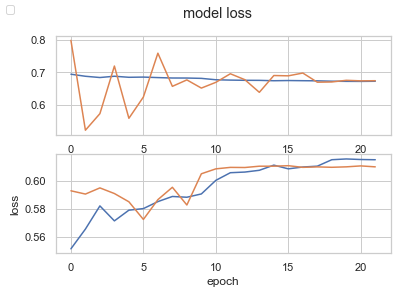

-----------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
142/142 [==============================] - 22s 74ms/step - loss: 0.7182 - auc: 0.5564 - val_loss: 0.6185 - val_auc: 0.5523
Epoch 2/100
142/142 [==============================] - 8s 60ms/step - loss: 0.6854 - auc: 0.5640 - val_loss: 0.4968 - val_auc: 0.5982
Epoch 3/100
142/142 [==============================] - 7s 51ms/step - loss: 0.6965 - auc: 0.5603 - val_loss: 0.8841 - val_auc: 0.5966
Epoch 4/100
142/142 [==============================] - 8s 57ms/step - loss: 0.6839 - auc: 0.5677 - val_loss: 0.6337 - val_auc: 0.5958
Epoch 5/100
142/142 [==============================] - 12s 85ms/step - loss: 0.6857 - auc: 0.5766 - val_loss: 0.6679 - val_auc: 0.6055
Epoch 6/100
142/142 [==============================] - 14s 99ms/step - loss: 0.6816 - auc: 0.5822 - val_loss: 0.3990 - val_auc: 0.6062
Epoch 7/100
142/142 [==============================] - 14s 99ms/step - loss: 0.6840 - auc: 0.5860

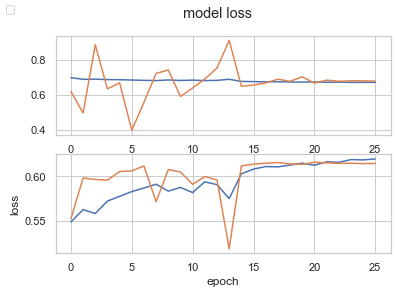

-----------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/100
142/142 [==============================] - 19s 64ms/step - loss: 0.7146 - auc: 0.5498 - val_loss: 0.6236 - val_auc: 0.5535
Epoch 2/100
142/142 [==============================] - 8s 59ms/step - loss: 0.6900 - auc: 0.5417 - val_loss: 0.6288 - val_auc: 0.5470
Epoch 3/100
142/142 [==============================] - 8s 54ms/step - loss: 0.6937 - auc: 0.5491 - val_loss: 0.4304 - val_auc: 0.5945
Epoch 4/100
142/142 [==============================] - 14s 101ms/step - loss: 0.6868 - auc: 0.5882 - val_loss: 0.5437 - val_auc: 0.5877
Epoch 5/100
142/142 [==============================] - 14s 101ms/step - loss: 0.6879 - auc: 0.5739 - val_loss: 0.5704 - val_auc: 0.5977
Epoch 6/100
142/142 [==============================] - 13s 95ms/step - loss: 0.6770 - auc: 0.5881 - val_loss: 0.6619 - val_auc: 0.5409
Epoch 7/100
142/142 [==============================] - 13s 90ms/step - loss: 0.6802 - auc: 0.5

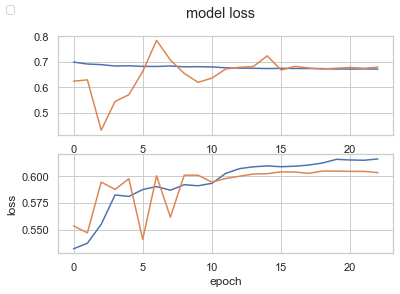

In [60]:
import keras
from keras.optimizers import adam_v2
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=8, min_lr=1e-6,verbose = 1)
custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=20
)

METRICS = [ 
      keras.metrics.AUC(name='auc'),
]

d1 = 0.15


#model definition
def create_model(learn_rate):
    model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.selu, kernel_initializer = initializers.he_normal,bias_initializer=initializers.he_normal, input_shape=(x_train.shape[1],)),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
    
    keras.layers.Dense(90, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(80, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(70, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(60, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(50, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(40, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(30, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(20, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(10, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
 keras.layers.Dense(1, activation=  'sigmoid')
 ])
    optimizer = adam_v2.Adam(lr=learn_rate)
    model.compile(loss='binary_crossentropy', metrics=[METRICS], optimizer=optimizer)
    return model

x_train = x_train_red
x_test = x_test_red

# Merge inputs and targets
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

max_n = 4.
num_folds = 5

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
confusions_matrix = []
for train, test in kfold.split(inputs, targets):
      # Compile the model
    model = create_model(0.1)
    
    X_train_res, y_train_res = inputs[train], targets[train]
    X_test_res, y_test_res = inputs[test], targets[test]
        
      # Generate a print
    print('-----------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model , class_weight=class_weight
    history = model.fit(X_train_res, y_train_res, class_weight=class_weights, validation_data=(X_test_res, y_test_res),batch_size=256, epochs=100,callbacks=[custom_early_stopping, reduce_lr])

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fig, axs = plt.subplots(2)
    fig.suptitle('model loss')
    fig.legend(['train', 'val'], loc='upper left')

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[1].plot(history.history['auc'])
    axs[1].plot(history.history['val_auc'])

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

      # Increase fold number
    fold_no = fold_no + 1

ROC AUC: 0.591
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.55      0.63      0.69      0.59      0.35      7891
          1       0.17      0.63      0.55      0.27      0.59      0.35      1186

avg / total       0.81      0.56      0.62      0.63      0.59      0.35      9077



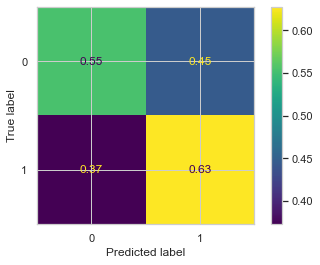

In [61]:
# Predict Neural network
y_pred = model.predict(x_test_red)
y_1 = np.round(y_pred)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

## PCA

In [67]:
process_data = data.copy()
process_data = process_data[process_data.readmitted != 1]
process_data = process_data.replace({'readmitted' : { 2 : 1}}) #output feacture
y = pd.DataFrame(process_data.readmitted.copy())
process_data = process_data.drop(columns=['readmitted'])
x_train, x_test, y_train, y_test = train_test_split_generator(process_data, y, False)

readmitted
0             31561
1              4745
dtype: int64
readmitted
0             7891
1             1186
dtype: int64


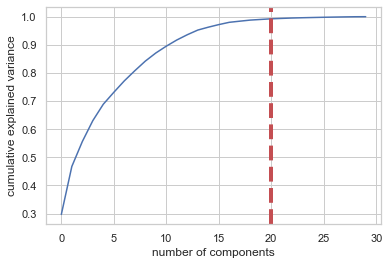

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.297262,0.297262
1,0.467634,0.170372
2,0.556158,0.088524
3,0.630550,0.074392
4,0.688949,0.058399
5,0.731213,0.042264
6,0.771861,0.040648
7,0.807878,0.036017
8,0.842054,0.034176
9,0.870920,0.028867


In [47]:
from sklearn.decomposition import PCA

pca_test = PCA()
pca_test.fit(x_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=20, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(20))

In [48]:
pca = PCA(n_components=20)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [56]:
clf_S1 = SVC(C=0.1, gamma=1, kernel='rbf').fit(x_train_pca, y_train, sample_weight=train_sample_weight)
clf_R1 = RandomForestClassifier(max_depth=6, n_estimators=300,class_weight=class_weights).fit(x_train_pca, y_train)

ROC AUC: 0.561
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.54      0.58      0.67      0.56      0.31      7891
          1       0.16      0.58      0.54      0.25      0.56      0.32      1186

avg / total       0.80      0.54      0.58      0.62      0.56      0.31      9077



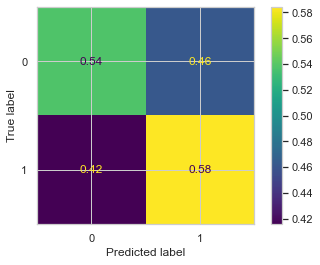

In [54]:
# Predict SVC
y_1 = clf_S1.predict(x_test_pca)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

ROC AUC: 0.580
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.62      0.54      0.73      0.58      0.34      7891
          1       0.18      0.54      0.62      0.27      0.58      0.33      1186

avg / total       0.81      0.61      0.55      0.67      0.58      0.34      9077



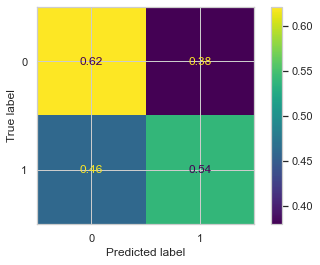

In [58]:
# Predict RandomForestClassifier
y_1 = clf_R1.predict(x_test_pca)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

-----------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
142/142 [==============================] - 13s 40ms/step - loss: 0.7064 - auc: 0.5359 - val_loss: 0.8603 - val_auc: 0.5869
Epoch 2/100
142/142 [==============================] - 5s 32ms/step - loss: 0.6875 - auc: 0.5601 - val_loss: 1.1656 - val_auc: 0.6070
Epoch 3/100
142/142 [==============================] - 5s 32ms/step - loss: 0.6874 - auc: 0.5754 - val_loss: 0.6233 - val_auc: 0.6051
Epoch 4/100
142/142 [==============================] - 4s 32ms/step - loss: 0.6827 - auc: 0.5811 - val_loss: 0.7500 - val_auc: 0.6041
Epoch 5/100
142/142 [==============================] - 5s 33ms/step - loss: 0.6848 - auc: 0.5648 - val_loss: 0.9807 - val_auc: 0.6046
Epoch 6/100
142/142 [==============================] - 5s 33ms/step - loss: 0.6847 - auc: 0.5866 - val_loss: 0.6943 - val_auc: 0.6067
Epoch 7/100
142/142 [==============================] - 4s 31ms/step - loss: 0.6976 - auc: 0.5785 - 

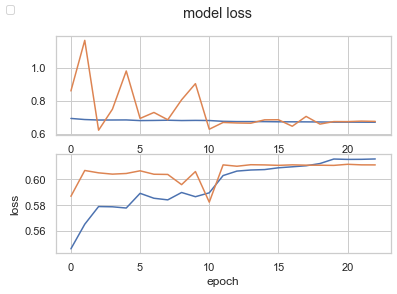

-----------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
142/142 [==============================] - 22s 92ms/step - loss: 0.7127 - auc: 0.5705 - val_loss: 1.1671 - val_auc: 0.5741
Epoch 2/100
142/142 [==============================] - 11s 78ms/step - loss: 0.6907 - auc: 0.5740 - val_loss: 1.1153 - val_auc: 0.5785
Epoch 3/100
142/142 [==============================] - 11s 79ms/step - loss: 0.6810 - auc: 0.5821 - val_loss: 0.7357 - val_auc: 0.5825
Epoch 4/100
142/142 [==============================] - 9s 62ms/step - loss: 0.6800 - auc: 0.5852 - val_loss: 0.9090 - val_auc: 0.5781
Epoch 5/100
142/142 [==============================] - 9s 63ms/step - loss: 0.6932 - auc: 0.5777 - val_loss: 0.9917 - val_auc: 0.5839
Epoch 6/100
142/142 [==============================] - 8s 58ms/step - loss: 0.6816 - auc: 0.5973 - val_loss: 0.9624 - val_auc: 0.5878
Epoch 7/100
142/142 [==============================] - 8s 59ms/step - loss: 0.6850 - auc: 0.5951 

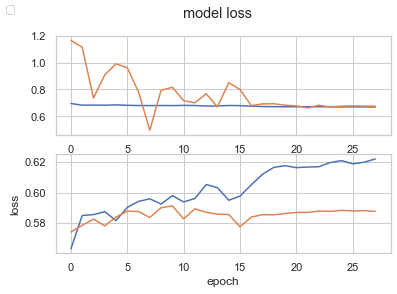

-----------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
142/142 [==============================] - 26s 75ms/step - loss: 0.7028 - auc: 0.5568 - val_loss: 0.7979 - val_auc: 0.5929
Epoch 2/100
142/142 [==============================] - 8s 57ms/step - loss: 0.6918 - auc: 0.5604 - val_loss: 0.5214 - val_auc: 0.5906
Epoch 3/100
142/142 [==============================] - 9s 61ms/step - loss: 0.6770 - auc: 0.5835 - val_loss: 0.5723 - val_auc: 0.5950
Epoch 4/100
142/142 [==============================] - 8s 59ms/step - loss: 0.6868 - auc: 0.5797 - val_loss: 0.7189 - val_auc: 0.5909
Epoch 5/100
142/142 [==============================] - 9s 64ms/step - loss: 0.6863 - auc: 0.5801 - val_loss: 0.5581 - val_auc: 0.5851
Epoch 6/100
142/142 [==============================] - 13s 89ms/step - loss: 0.6896 - auc: 0.5743 - val_loss: 0.6235 - val_auc: 0.5725
Epoch 7/100
142/142 [==============================] - 9s 62ms/step - loss: 0.6823 - auc: 0.5873 -

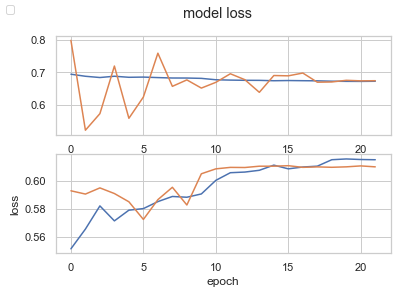

-----------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
142/142 [==============================] - 22s 74ms/step - loss: 0.7182 - auc: 0.5564 - val_loss: 0.6185 - val_auc: 0.5523
Epoch 2/100
142/142 [==============================] - 8s 60ms/step - loss: 0.6854 - auc: 0.5640 - val_loss: 0.4968 - val_auc: 0.5982
Epoch 3/100
142/142 [==============================] - 7s 51ms/step - loss: 0.6965 - auc: 0.5603 - val_loss: 0.8841 - val_auc: 0.5966
Epoch 4/100
142/142 [==============================] - 8s 57ms/step - loss: 0.6839 - auc: 0.5677 - val_loss: 0.6337 - val_auc: 0.5958
Epoch 5/100
142/142 [==============================] - 12s 85ms/step - loss: 0.6857 - auc: 0.5766 - val_loss: 0.6679 - val_auc: 0.6055
Epoch 6/100
142/142 [==============================] - 14s 99ms/step - loss: 0.6816 - auc: 0.5822 - val_loss: 0.3990 - val_auc: 0.6062
Epoch 7/100
142/142 [==============================] - 14s 99ms/step - loss: 0.6840 - auc: 0.5860

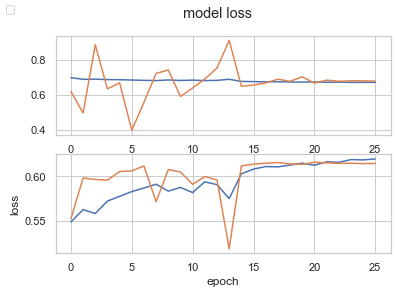

-----------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/100
142/142 [==============================] - 19s 64ms/step - loss: 0.7146 - auc: 0.5498 - val_loss: 0.6236 - val_auc: 0.5535
Epoch 2/100
142/142 [==============================] - 8s 59ms/step - loss: 0.6900 - auc: 0.5417 - val_loss: 0.6288 - val_auc: 0.5470
Epoch 3/100
142/142 [==============================] - 8s 54ms/step - loss: 0.6937 - auc: 0.5491 - val_loss: 0.4304 - val_auc: 0.5945
Epoch 4/100
142/142 [==============================] - 14s 101ms/step - loss: 0.6868 - auc: 0.5882 - val_loss: 0.5437 - val_auc: 0.5877
Epoch 5/100
142/142 [==============================] - 14s 101ms/step - loss: 0.6879 - auc: 0.5739 - val_loss: 0.5704 - val_auc: 0.5977
Epoch 6/100
142/142 [==============================] - 13s 95ms/step - loss: 0.6770 - auc: 0.5881 - val_loss: 0.6619 - val_auc: 0.5409
Epoch 7/100
142/142 [==============================] - 13s 90ms/step - loss: 0.6802 - auc: 0.5

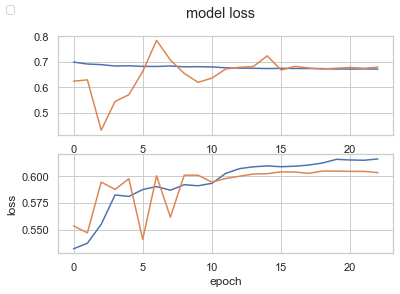

In [60]:
import keras
from keras.optimizers import adam_v2
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=8, min_lr=1e-6,verbose = 1)
custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=20
)

METRICS = [ 
      keras.metrics.AUC(name='auc'),
]

d1 = 0.15


#model definition
def create_model(learn_rate):
    model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.selu, kernel_initializer = initializers.he_normal,bias_initializer=initializers.he_normal, input_shape=(x_train.shape[1],)),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
    
    keras.layers.Dense(90, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(80, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(70, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(60, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.Dropout(d1),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(50, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(40, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(30, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(20, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
    keras.layers.Dense(10, activation=tf.nn.selu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        keras.layers.BatchNormalization(),
        
 keras.layers.Dense(1, activation=  'sigmoid')
 ])
    optimizer = adam_v2.Adam(lr=learn_rate)
    model.compile(loss='binary_crossentropy', metrics=[METRICS], optimizer=optimizer)
    return model

x_train = x_train_pca
x_test = x_test_pca

# Merge inputs and targets
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

max_n = 4.
num_folds = 5

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
confusions_matrix = []
for train, test in kfold.split(inputs, targets):
      # Compile the model
    model = create_model(0.1)
    
    X_train_res, y_train_res = inputs[train], targets[train]
    X_test_res, y_test_res = inputs[test], targets[test]
        
      # Generate a print
    print('-----------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model , class_weight=class_weight
    history = model.fit(X_train_res, y_train_res, class_weight=class_weights, validation_data=(X_test_res, y_test_res),batch_size=256, epochs=100,callbacks=[custom_early_stopping, reduce_lr])

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fig, axs = plt.subplots(2)
    fig.suptitle('model loss')
    fig.legend(['train', 'val'], loc='upper left')

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[1].plot(history.history['auc'])
    axs[1].plot(history.history['val_auc'])

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

      # Increase fold number
    fold_no = fold_no + 1

ROC AUC: 0.591
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.55      0.63      0.69      0.59      0.35      7891
          1       0.17      0.63      0.55      0.27      0.59      0.35      1186

avg / total       0.81      0.56      0.62      0.63      0.59      0.35      9077



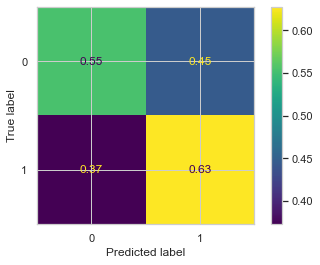

In [61]:
# Predict Neural network
y_pred = model.predict(x_test_pca)
y_1 = np.round(y_pred)
score = roc_auc_score(y_test, y_1)
#score = roc_auc_score(y_test, clf_1.predict_proba(x_test), multi_class='ovr')
print('ROC AUC: %.3f' % score)
print(classification_report_imbalanced(y_test, y_1))
cm = metrics.confusion_matrix(y_test, y_1, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()